In [64]:
import torch
import torchaudio
from torch.utils.data import DataLoader
import pathlib
import matplotlib.pyplot as plt

# Resources of audio preprocessing functions
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

In [65]:
# random seed
torch.manual_seed(0)

In [66]:
# Load LJSpeech locally
root = pathlib.Path('/Users/lukgar/Desktop/exjobb/datasets')
ljspeech = torchaudio.datasets.LJSPEECH(root, download=False)
data_loader = DataLoader(ljspeech, batch_size=1, shuffle=False)

In [67]:
# Get 4th file in data_loader
for i, data in enumerate(data_loader):
    if i == 3:
        break
waveform = data[0].squeeze(0)
sample_rate = data[1].item()

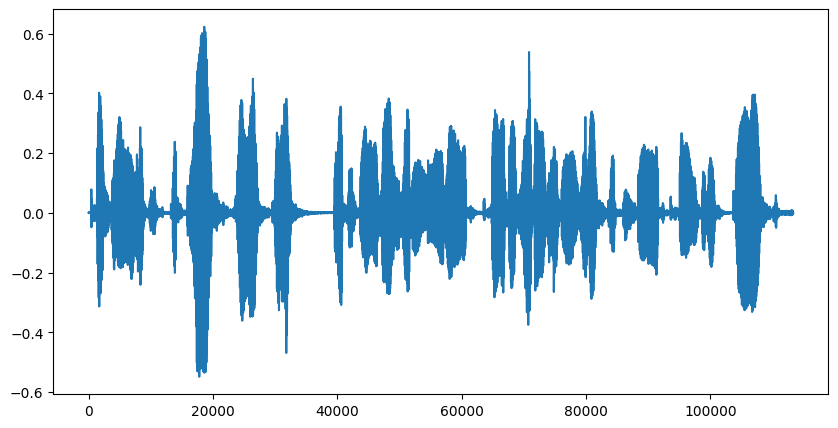

In [68]:
# Plot waveform
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(waveform.t().numpy());

In [69]:
n_fft = 1024 # FFT size, creates n_fft/2+1 bins
win_length = 1024 # Window size (bredd)
hop_length = win_length // 2 # Determines overlap
pad = 0

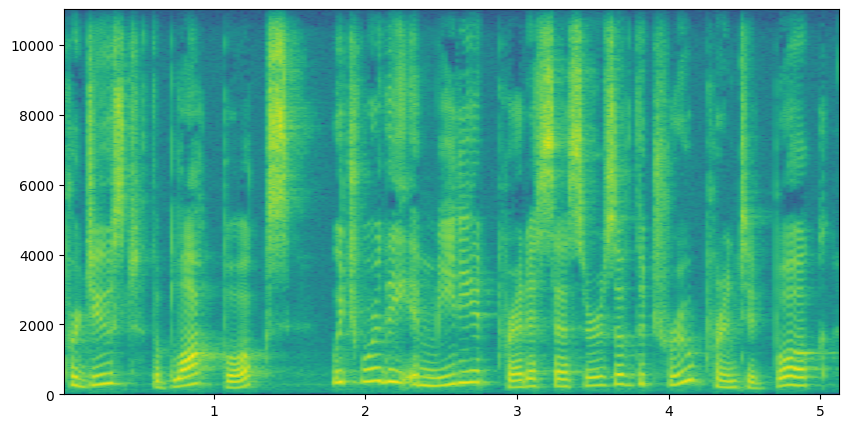

In [70]:
# plot spectrogram
plt.figure()
plt.specgram(
    waveform[0].t().numpy(),
    Fs=sample_rate,
    NFFT=n_fft,
    noverlap=hop_length,
    scale='dB',
    );

In [71]:
import librosa
def plot_spectrogram(spec, title=None, db=True, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    if db: spec = librosa.power_to_db(spec)
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

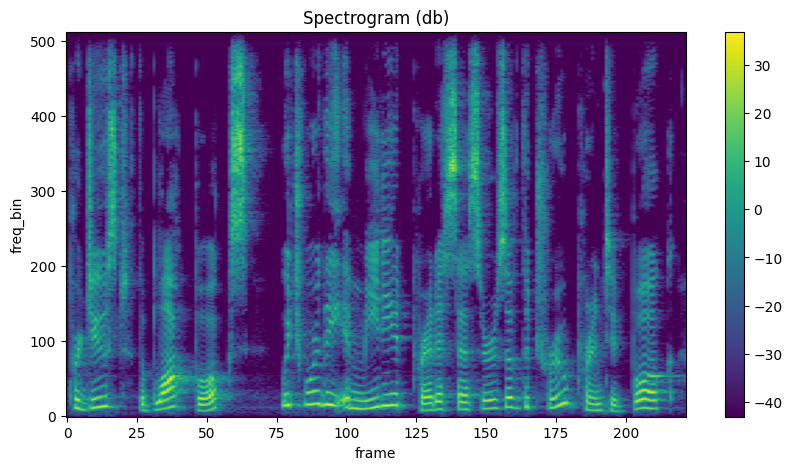

In [72]:
import torchaudio.transforms as T

spec_transform = T.Spectrogram(
    n_fft=1024,
    win_length=win_length,
    hop_length=hop_length,
    pad=pad,
)

spectrogram = spec_transform(waveform)

plot_spectrogram(spectrogram[0].numpy(), ylabel="freq_bin", db=True)



torch.Size([1, 513, 222])
tensor(221.)
length of waveform: 113309
length of envelope: torch.Size([113309])


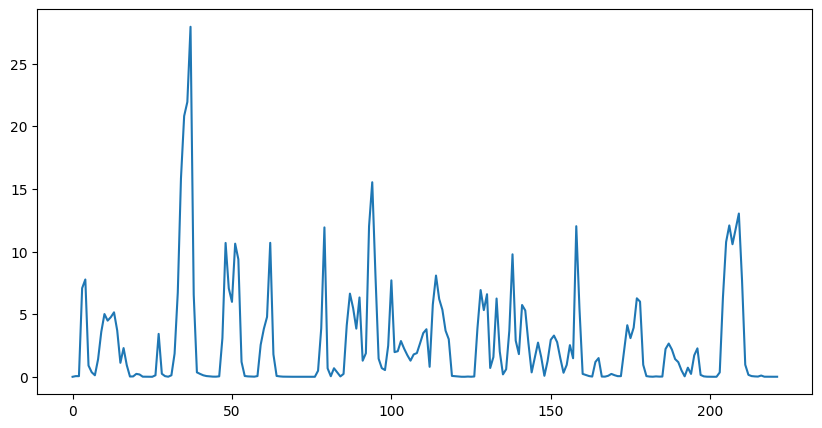

In [85]:
print(spectrogram.shape)
spec_summed = torch.mean(spectrogram, dim=1)
# spec_summed /= torch.max(spec_summed)
# normalize
spec_len = spec_summed.shape[1]

# create a tensor of linearly spaced points from 0 and length of spec_summed
x = torch.linspace(0, spec_len-1, spec_len)
print(x[-1])

spec_summed.shape
wav_length = waveform.shape[1]
print(f"length of waveform: {wav_length}")

envelope = torch.zeros(wav_length)
print(f"length of envelope: {envelope.shape}")

x *= (wav_length-1) / (spec_len-1)
# round to closest integer
x = torch.round(x)

# insert values from spec_summed into envelope at the indices of x
envelope[x.long()] = spec_summed

plt.figure()
plt.plot(spec_summed[0].t().numpy());
#plt.plot(envelope.t().numpy());

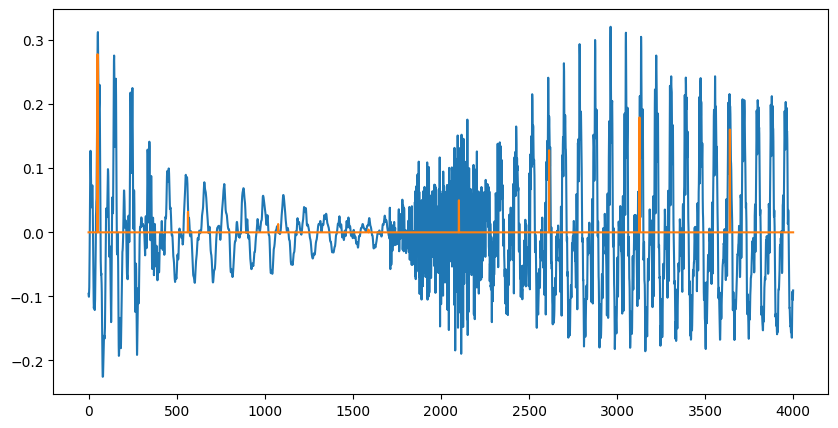

In [83]:
plt.figure()
width = 4000
start = 2000
plt.plot(waveform.t()[start:start+width].numpy());
plt.plot(envelope.t()[start:start+width].numpy());

In [87]:
from librosa.filters import mel as librosa_mel_fn
from params import params

mel_basis = {}
hann_window = {}

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def get_mel(audio, params, center=False):
    n_fft = params.n_fft
    num_mels = params.n_mels
    sampling_rate = params.sample_rate
    hop_size = params.hop_samples
    win_size = params.hop_samples * 4
    fmin = params.fmin
    fmax = params.fmax

    y = audio.unsqueeze(0)

    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    # complex tensor as default, then use view_as_real for future pytorch compatibility
    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)
    spec = torch.view_as_real(spec)
    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [88]:
melspec = get_mel(waveform[0], params)

/var/folders/z2/tk2lft293nx9kvc_4tpd4bh80000gp/T/ipykernel_30048/2919060022.py:32: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax)


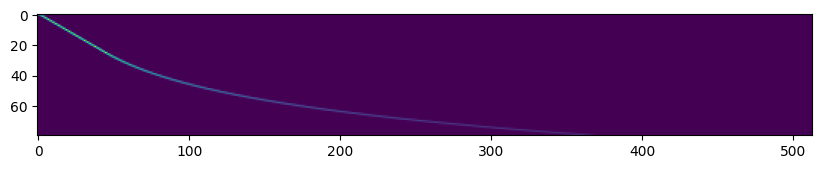

In [98]:
plt.imshow(mel_basis['8000_cpu'].numpy());

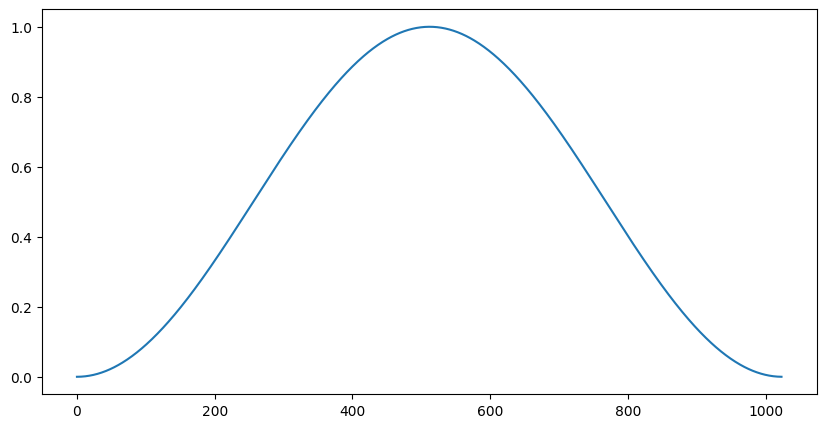

In [101]:
# plot hann window
plt.figure()
plt.plot(hann_window['cpu'].numpy());

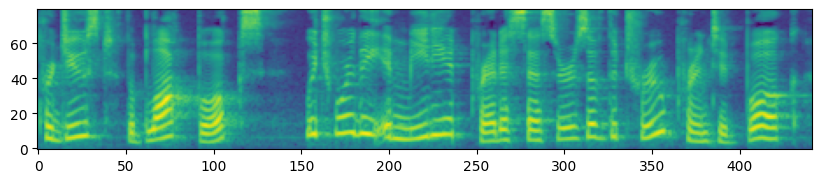

In [100]:
plt.imshow(melspec[0].numpy(), origin='lower');

In [153]:
def get_std(spectrogram, energy_min=None, energy_max=None):
    # We should probably use the same normalization for all spectrograms
    # Now we're using the individual min and max for each spectrogram

    energy = (spectrogram.exp()).sum(dim=1).sqrt()

    if energy_min is None:
        energy_min = torch.min(energy)
    if energy_max is None:
        energy_max = torch.max(energy)

    # normalization
    target_std = torch.clamp((energy - energy_min) / (energy_max - energy_min), params.std_min, None)
    return target_std[0]

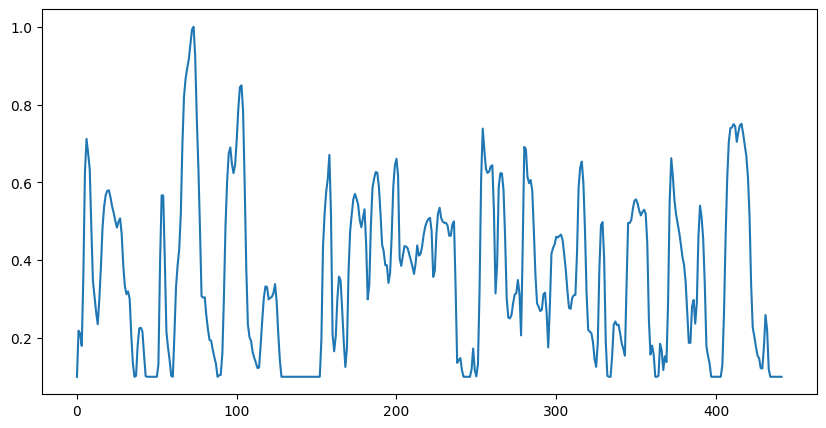

In [154]:
std = get_std(melspec)
plt.plot(std.numpy());

length of std: 442
length of waveform: 113152
length of envelope: torch.Size([113152])


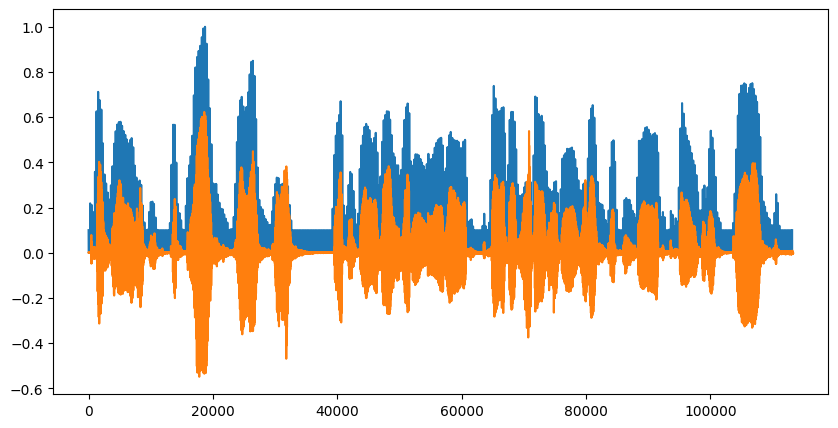

In [162]:

std_len = std.shape[0]
print(f"length of std: {std_len}")

x = torch.linspace(0, std_len-1, std_len)

# wav_length = waveform.shape[1]
wav_length = params.hop_samples * melspec.shape[-1]
print(f"length of waveform: {wav_length}")

envelope = torch.zeros(wav_length)
print(f"length of envelope: {envelope.shape}")

x *= (wav_length-1) / (std_len-1)
# round to closest integer
x = torch.round(x)

# insert values from spec_summed into envelope at the indices of x
envelope[x.long()] = std

plt.figure()
plt.plot(envelope.t().numpy());
plt.plot(waveform.t().numpy());



In [164]:
# Match envelope length to

starting_noise = torch.randn(melspec.shape[0], params.hop_samples * melspec.shape[-1]) * std
print(params.hop_samples * melspec.shape[-1])
plt.plot(starting_noise[0].numpy());

# How do we perform the broadcasted multiplication?

RuntimeError: The size of tensor a (113152) must match the size of tensor b (442) at non-singleton dimension 1